# FashionMNIST Image Classification with CNN in PyTorch

This notebook demonstrates a basic convolutional neural network (CNN) applied to the FashionMNIST dataset using PyTorch. The goal is to classify grayscale images of clothing into one of 10 categories such as T-shirt/top, Trouser, Sneaker, etc.

Notebook structure:
- Data loading and preprocessing
- CNN model definition
- Training and evaluation
- Visualizations of performance

# Imports

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import plot_decision_boundary, plot_predictions, accuracy_fn
from pathlib import Path

#torchvision imports
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#for timing the model runtime
from timeit import default_timer as timer

#for progress bar
from tqdm.auto import tqdm


In [ ]:
#key libraries
#torchvision
#torchvision.datasets
#torchvision.models give pretrianed computer vision models
#torchvision.transforms: manipulating vision data

#torch.utils.data.Dataset : base Dataset class
#torch.utils.data.DataLoader : creates python iterable over dataset
print(torchvision.__version__)

0.22.0


## Dataset: FashionMNIST

FashionMNIST is a dataset of 28x28 grayscale images of clothing items, with 10 total classes:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

The dataset is split into 60,000 training images and 10,000 test images. PyTorch's `torchvision.datasets` module is used for loading and transforming the data into tensors.


In [ ]:
#Step 1 is getting a dataset
#FashionMNIST

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, #test data
    download=True,
    transform=torchvision.transforms.ToTensor()
)



In [ ]:
len(train_data), len(test_data), type(train_data[0]), len(train_data[0])

(60000, 10000, tuple, 2)

In [ ]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
#pytorch defaults to BCHW : batch, color, height, width

class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
image.shape, class_names[label] #label is int

#black and white image so first index is 1. BCHW for pytorch!!

(torch.Size([1, 28, 28]), 'Ankle boot')

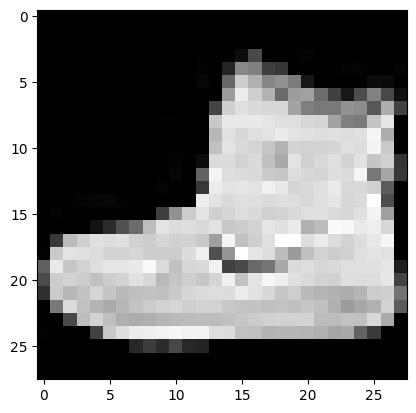

In [ ]:
#visualizing data
plt.imshow(image.squeeze(),
        cmap="gray") #matplotlib expects BHWC, so we can just squeeze the 1

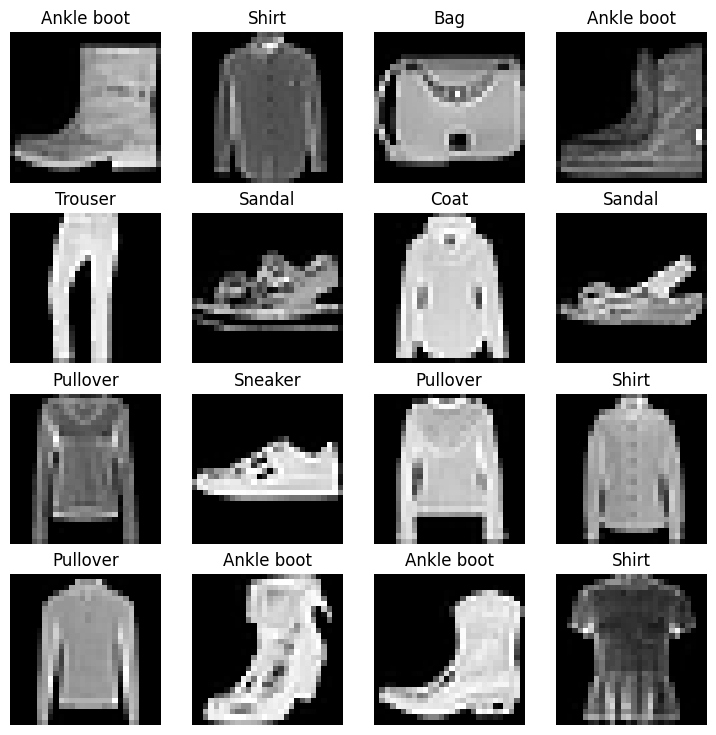

In [ ]:
import random

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() #returns a scalar
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

# DataLoader

DataLoader turns the dataset into a Python iterable, this is to turn the massive dataset into batches which is computationally effecient, and has better memory utilization.

In [ ]:
BATCH_SIZE = 32

#turn dataset into batches
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
#check what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape #BCHW is right there

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

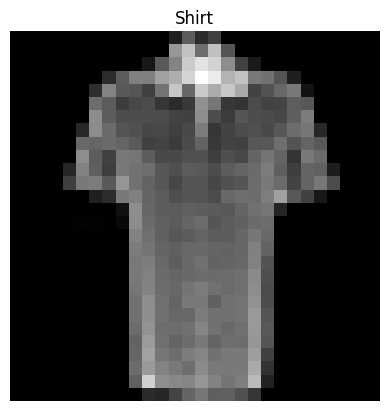

In [ ]:
#visualize a batch or a single image from a batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [ ]:
#start with baseline models
#images require a flatten layer.

#needed because nn.Linear only accepts [batch_size, features] shaped inputs

flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
class MNISTFashion1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                    out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
#instantiate the model
model_0 = MNISTFashion1(
    input_shape=784, #output of flatten
    hidden_units=32,
    output_shape=len(class_names) #one for each class
).to("cpu")

model_0, model_0.state_dict()

(MNISTFashion1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=32, bias=True)
     (2): Linear(in_features=32, out_features=10, bias=True)
   )
 ),
 OrderedDict([('layer_stack.1.weight',
               tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                       [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                       [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                       ...,
                       [-0.0023,  0.0071,  0.0330,  ...,  0.0164, -0.0095, -0.0053],
                       [ 0.0167, -0.0324,  0.0086,  ..., -0.0090,  0.0203, -0.0100],
                       [-0.0118,  0.0119, -0.0080,  ..., -0.0193,  0.0170,  0.0246]])),
              ('layer_stack.1.bias',
               tensor([ 0.0161, -0.0159,  0.0234,  0.0084, -0.0339, -0.0047, -0.0323, -0.0125,
                        0.0065, -0.0339, -0.0036,  0.0208,  0.0018,

In [ ]:
#random test with dummy x to check if the shapes are correct
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x), model_0(dummy_x).shape

(tensor([[ 0.0461, -0.1040,  0.2095,  0.0458, -0.0841, -0.3552,  0.0832, -0.1319,
           0.1477,  0.0418]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 10]))

In [ ]:
#set up loss and optimizer and evaluation metrics

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

#accuracy = accuracy_fn() #imported from helper_functions.py

In [ ]:
#creating functions to time our experiments:
#trakcing metrics; model performance and time (how fast it runs)
#often a tradeoff between the two

start_time = timer() #placed afterwards to see how fast this cell runs
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
    total_time = end - start
    print(f"Train time on device: {device}: {total_time:.3f} seconds")
    return total_time


end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")


Train time on device: cpu: 0.000 seconds


4.1749997762963176e-05

## Model Training

The model is trained for N epochs using a standard training loop. We track training loss and accuracy to evaluate learning progress. A validation/test set is used for final evaluation.

Steps:
- Loop through the batches
- Loop through training batches, perform training steps and calculate the train loss per batch
- Loop through testing batches, perform testing steps, calculate the test loss per batch
- Print results


In [ ]:
torch.manual_seed(42)

train_time_start_on_cpu = timer()

epochs=3

#training and test loop

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader): #basically X, y represents image, label here but use X and y for convention
        
        model_0.train()

        #fwd pass
        y_pred = model_0(X)

        #calc loss
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumilates train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        #print
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
    
    #divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ##TESTING LOOP

    test_loss, test_acc = 0, 0

    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            
            #fwd pass
            test_pred = model_0(X)
            #loss
            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y,
                                   y_pred=test_pred.argmax(dim=1)) #logits to probability
            
        #test loss and acc average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                                end=train_time_end_on_cpu,
                                                device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train loss: 0.4117 | Test loss: 0.4544, Test acc: 84.17%

Epoch: 1
----
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train loss: 0.4107 | Test loss: 0.4570, Test acc: 84.20%

Epoch: 2
----
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train loss: 0.4082 | Test loss: 0.4617, Test acc: 84.23%

Train time on device: cpu: 5.279 seconds


In [ ]:
#Make predictions and get model results

def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn,
               device):
    """
    Returns a dictionary containing the results of model predicting on data_loader.
    """

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            #make preds
            #make data device agnostic
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)

            #accumulate loss and acc per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0,
                             data_loader = test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device='cpu')

model_0_results #This summarizes the baseline model

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTFashion1',
 'model_loss': 0.46171027421951294,
 'model_acc': 84.22523961661342}

In [ ]:
#Now build model 1 and set up device agnostic code to run on the gpu/mps

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [ ]:
#Does this dataset require non-linearities?

class MNISTFashion2(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features= output_shape)
            )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
model_1 = MNISTFashion2(input_shape=784,
                        hidden_units=10,
                        output_shape=len(class_names)).to(device)

model_1, model_1.state_dict()

(MNISTFashion2(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 OrderedDict([('layer_stack.1.weight',
               tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                       [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                       [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                       ...,
                       [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                       [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                       [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
                      device='mps:0')),
              ('layer_stack.1.bias',
               tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
            

In [ ]:
#loss fucntion and optimizer

loss_fn = nn.CrossEntropyLoss() #measures how wrong the model is
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
#optmimizer tries to update the model parameters to minimize the loss


In [ ]:
#time to make a function for the training loop and testing loop

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs training step with model trying to learn on 
    data_loader."""
    
    train_loss, train_acc = 0, 0
    
    model.train()

    for batch, (X, y) in enumerate(data_loader): #basically X, y represents image, label here but use X and y for convention

        #Send data to device
        X, y = X.to(device), y.to(device)  
        

        #fwd pass
        y_pred = model(X)

        #calc loss and acc
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumilates train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    #divide total train loss by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train Loss : {train_loss:.3f} | Train acc : {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
            #   optimizer: torch.optim.Optimizer, not need in test step
              accuracy_fn,
              device: torch.device = device):
    """performs a testing loop step on model going over data_loader"""
    
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            #send data to target device
            X, y = X.to(device), y.to(device)
            #fwd pass
            test_pred = model(X)

            #loss and acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)) #logits to prediction labels
            

        #adjust metrics and print out
        test_loss /= len(data_loader) #average across a whole batch, per step
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
#create optimization loop

#measure time:
train_time_start_on_gpu = timer()

epochs = 3

#create the optimization loop using the two functions we defined
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----")
    
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----
Train Loss : 0.644 | Train acc : 77.08%
Test loss: 0.542 | Test acc: 80.68%

Epoch: 1 
----
Train Loss : 0.478 | Train acc : 83.19%
Test loss: 0.466 | Test acc: 83.53%

Epoch: 2 
----
Train Loss : 0.444 | Train acc : 84.48%
Test loss: 0.491 | Test acc: 83.20%

Train time on device: mps: 14.042 seconds


In [ ]:
#model performance didn't really improve, so we keep on moving
#with model improvement and testing

model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)


  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
model_0_results, model_1_results

({'model_name': 'MNISTFashion1',
  'model_loss': 0.46171027421951294,
  'model_acc': 84.22523961661342},
 {'model_name': 'MNISTFashion2',
  'model_loss': 0.4905567467212677,
  'model_acc': 83.19688498402556})

In [ ]:
#Model 2: CNN ConvNets
class MNISTFashion3(nn.Module):
    """Model that replicates TinyVGG"""
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        #Architecutre > Blocks > Layers
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, #hyperparameter
                      stride=1, #hyperparameter
                      padding=1), #hyperparameter
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, #hyperparameter
                      stride=1, #hyperparameter
                      padding=1), #hyperparameter
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, #hyperparameter
                      stride=1, #hyperparameter
                      padding=1), #hyperparameter
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, #hyperparameter
                      stride=1, #hyperparameter
                      padding=1), #hyperparameter
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=490, #there's a trick to calculate this
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
       # print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape) #this shape will guide what the input shape into the next layer would be. check later, this is (10,7,7) so it will be 490
        x = self.classifier_layer(x)
        return x

In [ ]:
torch.manual_seed(42)
model_2 = MNISTFashion3(input_shape=1, # no of channels, 1 for BW, 3 for colored
                        hidden_units=10,
                        output_shape=len(class_names)).to(device)

model_2

MNISTFashion3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
#Understanding Conv2d with toy data

torch.manual_seed(42)

#create batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [ ]:
#single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, #this time our toy data has RGB
                         out_channels=10, #no of hidden neurons
                         kernel_size=3, #or (3,3) a tuple
                         padding=0,
                         stride=1)

#pass toy data through this layer
print(test_image.shape)
conv_output = conv_layer(test_image)
print(conv_output.shape)

#single maxpool2d layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_output = maxpool_layer(test_image)
print(maxpool_output.shape) #takes max of value across the kernel

#passing output of conv through maxpool
conv_through_maxpool = maxpool_layer(conv_output)
print(conv_through_maxpool.shape)

torch.Size([3, 64, 64])
torch.Size([10, 62, 62])
torch.Size([3, 32, 32])
torch.Size([10, 31, 31])


In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

## Evaluation and Results

The trained model is evaluated on the test set. Accuracy and loss are computed, and optional visualizations (e.g., confusion matrix or sample predictions) help assess performance.

Typical accuracy for a basic CNN on FashionMNIST can range from 85% to 92%, depending on architecture and training time.


In [ ]:
torch.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss : 0.513 | Train acc : 81.38%
Test loss: 0.365 | Test acc: 86.83%

Epoch: 1
---------
Train Loss : 0.335 | Train acc : 87.99%
Test loss: 0.328 | Test acc: 88.54%

Epoch: 2
---------
Train Loss : 0.298 | Train acc : 89.34%
Test loss: 0.296 | Test acc: 89.10%

Train time on device: mps: 19.100 seconds


In [ ]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTFashion3',
 'model_loss': 0.2960469424724579,
 'model_acc': 89.09744408945687}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results



,model_name,model_loss,model_acc
0,MNISTFashion1,0.461710,84.225240
1,MNISTFashion2,0.490557,83.196885
2,MNISTFashion3,0.296047,89.097444


In [ ]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,MNISTFashion1,0.461710,84.225240,5.279207
1,MNISTFashion2,0.490557,83.196885,14.041817
2,MNISTFashion3,0.296047,89.097444,19.099531
